#### Инициализация

In [12]:
'''Импорт библиотек'''
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
import cv2
#pip install opencv-python
import numpy as np
from lmfit.models import GaussianModel
gauss = GaussianModel()

'''Подавление предупреждений срабатывания lmfit.GaussModel.guess() -- она создаёт UFloat'''
import warnings
warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0")

rows, columns = (768, 1024)
'''Калибровка камеры флуоресценции'''# [cm/px]
Kx_flu = 6.7/1024 
Ky_flu = 8.9/768

#### Обработка поглощения

In [13]:
file_abs = "image_9"
directory = r"../2025-06-20_AbIm-Calibr//"
#directory = r"../..//" #desktop

'''Чтение и разбиение файла'''
img = PIL.Image.open(directory + file_abs + ".tif") #initially a grayscale image

shots = []
try:
    while True:
        frame = np.array(img)
        shots.append(frame)
        img.seek(img.tell() + 1) #go to next frame
except EOFError: #end of frames case
    pass

I_atoms = shots[0] #I
I_lbeam = shots[1] #I0
bias = shots[2]

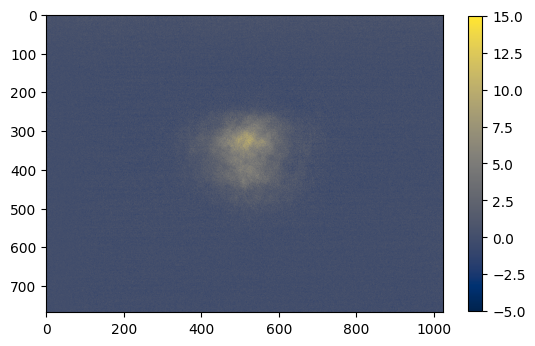

In [14]:
'''Приведение к uint16 и замена нулей, чтобы не возникало ошибок при делении матриц'''
num = (I_atoms - bias).astype(np.uint16) + 1
denom = (I_lbeam - bias).astype(np.uint16) + 1

'''Определение пропускания T(x,y)'''
T = (num/denom).astype(np.float32)

'''Визуализация'''
D = I_lbeam.astype(np.int16)-I_atoms.astype(np.int16)
plt.imshow(D, cmap="cividis")
plt.colorbar(shrink=.8)

#### Поиск центра облака

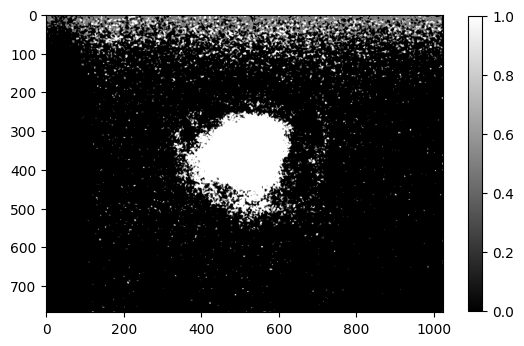

In [15]:
'''Фильтрация физичных T<=1'''
F = np.copy(T)
for i in range(rows): #rows
    for j in range(columns): #columns
        if T[i, j] > 1:
            F[i, j] = 1

ker = 57
'''Сглаживание шумов'''
M = cv2.medianBlur(F, 5)
G = cv2.GaussianBlur(M, (ker, ker), 0)

'''Фильтрация пропускания меньше порогового значения'''
TRSH = 0.90 #пороговое значение
_, binary = cv2.threshold(M, TRSH, 1, cv2.THRESH_BINARY_INV)
# THRESH_BINARY_INV:
#  ≤ TRSH = белые
#  > TRSH = черные

'''Визуализация'''
plt.imshow(binary, cmap="gray")
plt.colorbar(shrink=.8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..256.0].


Критическое пропускание	Tc: 0.6761106252670288
Критическая точка	C: (353, 513) 


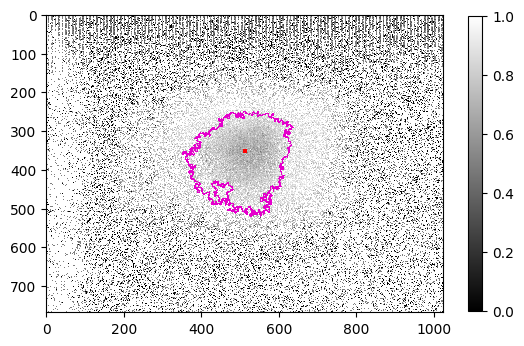

In [16]:
'''Выделение контура поглощения'''
contours, _ = cv2.findContours(binary.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
assert contours != (), "Err: no contours found"
    
largest_contour = max(contours, key=cv2.contourArea)

ROI = np.zeros_like(T, dtype=np.uint8)
cv2.drawContours(ROI, [largest_contour], -1, 255, thickness=cv2.FILLED)

'''Нахождение минимума пропускания в нём'''
min_val, _, (jc_abs, ic_abs), _ = cv2.minMaxLoc(G, mask=ROI)
print(f"Критическое пропускание\tTc: {min_val}\nКритическая точка\tC: {(ic_abs, jc_abs)} ")

'''Отрисовка полученного контура'''
output = cv2.cvtColor(T, cv2.COLOR_GRAY2BGR)  # Переводим в BGR для рисования
cv2.drawContours(output, [largest_contour], -1, (.9, 0, .8), 2)
cv2.circle(output, (jc_abs, ic_abs), 6, (1., 0, 0), -1)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output, interpolation='none', cmap="gray")
plt.colorbar(shrink=.8)

#### Обработка центральной горизонтали

fwhm: 187.130 ± 1.361 px
peak absorption: 33.443% ± 0.211%
________________________________
χ²-reduced: 0.000
>1 -- model lacks freedom
<1 -- model has too much freedom (overfit)
Fit explains 96.437% of data (R² param)


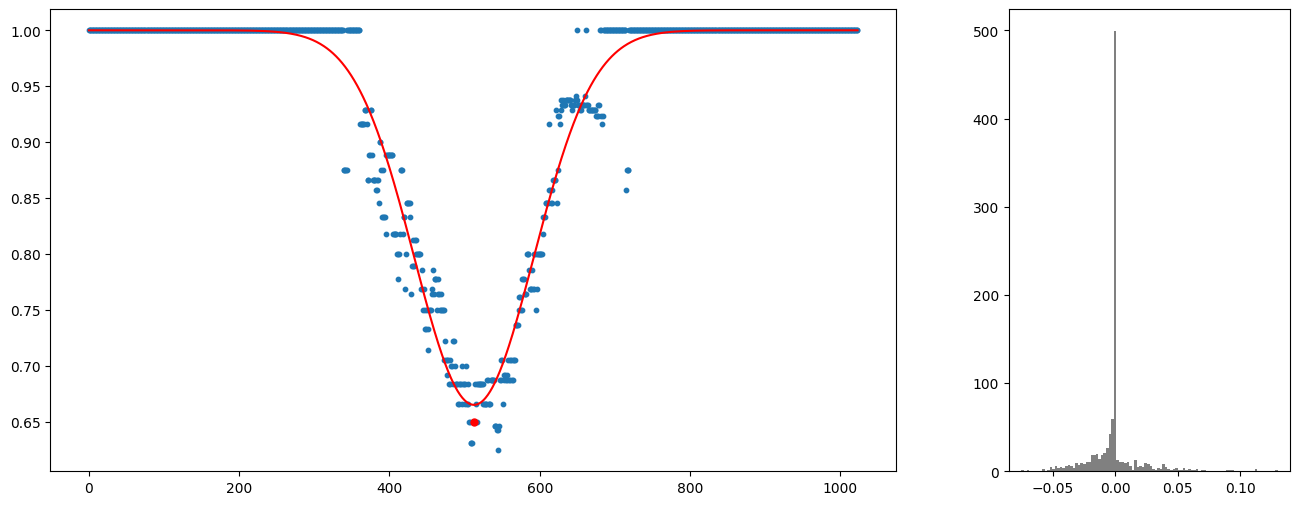

In [17]:
'''Профиль по оси j (для величины w_x)'''
data = 1-M[ic_abs, :]
arg = np.arange(0, columns, 1)

'''Фитирование нормальным распределением'''
pars = gauss.guess(data, x=arg) #затравочные параметры
out = gauss.fit(data, pars, x=arg, calc_covar=False)

residuals = data - out.best_fit
fwhm_abs = out.params["fwhm"].value
w_abs = out.params["sigma"].value

print("fwhm: %.3f ± %.3f px" % (fwhm_abs, out.params["fwhm"].stderr)) #stderr соответствует p = 0.68 (1-сигма)
#print("w_x: %.3f ± %.3f px" % (w_abs, out.params["sigma"].stderr))
print("peak absorption: %.3f%% ± %.3f%%" % (out.params["height"].value*100, out.params["height"].stderr*100))
print("________________________________")
print("χ²-reduced: \033[31m%.3f\033[0m" % out.redchi)
print(">1 -- model lacks freedom")
print("<1 -- model has too much freedom (overfit)")
print("Fit explains \033[31m%.3f\033[0m%% of data (R² param)" % (out.rsquared*100))

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 6))
ax[0].scatter(arg, 1-data, s=10)
ax[0].plot(arg, 1-out.best_fit, "r-")
ax[0].plot(jc_abs, 1-data[jc_abs], 'r.', markersize=10)
ax[1].hist(residuals.flatten(), bins=100, color="gray")
plt.show()

#### Обработка флуоресценции

(768, 1024)

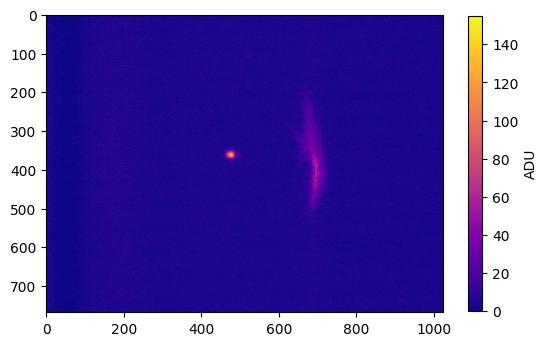

In [18]:
file_flu = "image_0"

I_fluor = cv2.imread(directory + file_flu + ".tif", cv2.IMREAD_GRAYSCALE)
plt.imshow(I_fluor, cmap="plasma")
plt.colorbar(shrink=.8, label="ADU") #[Analog-to-Digital Units]
I_fluor.shape

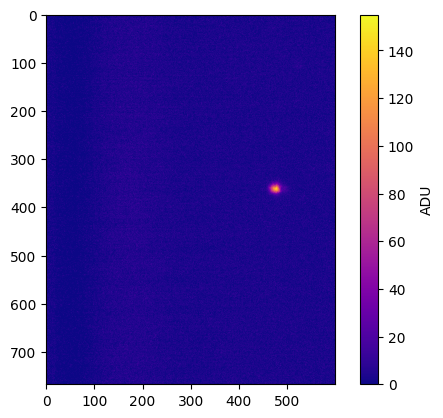

In [19]:
'''Выделение области интереса (обрезание блика)'''
(i1, i2) = (0, 768)
(j1, j2) = (0, 600)
I_cr = I_fluor[i1:i2,j1:j2]
plt.imshow(I_cr, cmap="plasma")
plt.colorbar(shrink=1, label="ADU") #[Analog-to-Digital Units]

In [20]:
'''Нахождение максимума флуоресценции в нём'''
_, max_val, _, (jc_flu, ic_flu) = cv2.minMaxLoc(I_cr)
print(f"Критическое свечение\tIc: {max_val}\nКритическая точка\tC: {(ic_flu, jc_flu)} ")

Критическое свечение	Ic: 155.0
Критическая точка	C: (361, 477) 


fwhm: 187.130 ± 0.380 px
peak absorption: 13097.415% ± 240.030%
________________________________
χ²-reduced: 51.869
>1 -- model lacks freedom
<1 -- model has too much freedom (overfit)
Fit explains 86.379% of data (R² param)


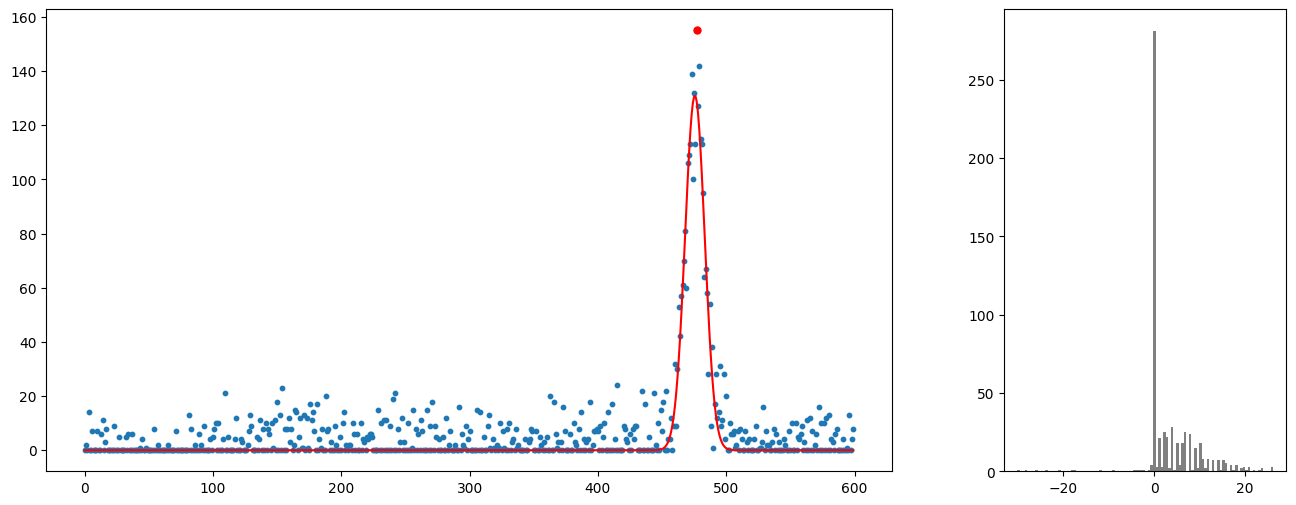

In [21]:
'''Профиль по оси j (для величины w_x)'''
data = I_cr[ic_flu, :]
arg = np.arange(0, j2-j1, 1)

'''Фитирование нормальным распределением'''
pars = gauss.guess(data, x=arg) #затравочные параметры
out = gauss.fit(data, pars, x=arg, calc_covar=False)

residuals = data - out.best_fit
fwhm_flu = out.params["fwhm"].value
w_flu = out.params["sigma"].value

print("fwhm: %.3f ± %.3f px" % (fwhm_abs, out.params["fwhm"].stderr)) #stderr соответствует p = 0.68 (1-сигма)
#print("w_x: %.3f ± %.3f px" % (w_abs, out.params["sigma"].stderr))
print("peak absorption: %.3f%% ± %.3f%%" % (out.params["height"].value*100, out.params["height"].stderr*100))
print("________________________________")
print("χ²-reduced: \033[31m%.3f\033[0m" % out.redchi)
print(">1 -- model lacks freedom")
print("<1 -- model has too much freedom (overfit)")
print("Fit explains \033[31m%.3f\033[0m%% of data (R² param)" % (out.rsquared*100))

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 6))
ax[0].scatter(arg, data, s=10)
ax[0].plot(arg, out.best_fit, "r-")
ax[0].plot(jc_flu, data[jc_flu], 'r.', markersize=10)
ax[1].hist(residuals.flatten(), bins=100, color="gray")
plt.show()

In [22]:
'''Калибровка камеры поглощения'''
Kx_abs = Kx_flu*fwhm_flu/fwhm_abs #из предположения что fwhm равны в [cm]
print(Kx_abs)

0.0006272973203202318
